In [56]:
import numba
from numba import jit

In [43]:
%load_ext cython

In [57]:
# from Algorithm 1: HMC, page1353
@jit
def Leapfrog(theta, r, grad, eps, L):
    r_tilde = r + (eps/2) * grad
    theta_tilde = theta + eps * r_tilde
    logp_tilde, grad_tilde = L(theta_tilde)
    r_tilde = r_tilde + (eps/2) * grad_tilde
    return theta_tilde, r_tilde, grad_tilde, logp_tilde

In [58]:
@jit
def FindReasonableEpsilon(theta, grad, logp, L):
    #initialize
    parems = len(theta)
    eps = 1
    r = np.random.multivariate_normal(np.zeros(parems), np.identity(parems), 1)
    r = r.ravel()
    theta_prime, r_prime, _, logp_prime = Leapfrog(theta, r, grad, eps, L)
    
    prob = np.exp(logp_prime - logp - 0.5 * (np.dot(r_prime, r_prime) - np.dot(r, r)))
    a = 2 * int(prob > 0.5) - 1

    while prob**a > 2**(-a):
        eps = 2**a * eps
        theta_prime, r_prime, _, logp_prime = Leapfrog(theta, r, grad, eps, L);
        prob = np.exp(logp_prime - logp - 0.5 * (np.dot(r_prime, r_prime) - np.dot(r,r)))
    return eps

In [59]:
@jit
def BuildTree(theta, r, grad, u, v, j, eps, L, esto0):
    if j == 0: 
        # base case, take one leapfrog step in the direction v
        theta_prime, r_prime, grad_prime, logp_prime = Leapfrog(theta, r, grad, v*eps, L)
        
        esto = logp_prime - 0.5 * np.dot(r_prime, r_prime)

        n_prime = int(u <= np.exp(esto))
        
        s_prime = int(esto > np.log(u) - 1000)

        alpha_prime = min(1, np.exp(esto - esto0))
                                                   
        return theta_prime, r_prime, grad_prime, theta_prime, r_prime, grad_prime, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha_prime, 1
    else:
        # recursion, build left and right subtrees
        theta_minus, r_minus, grad_minus, theta_plus, r_plus, grad_plus, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha_prime, n_alpha_prime = BuildTree(theta, r, grad, u, v, j-1, eps, L, esto0)
        
        if s_prime == 1:
            if v == -1:
                theta_minus, r_minus, grad_minus, _,_,_, theta_doub_prime, grad_doub_prime, logp_doub_prime, n_doub_prime, s_doub_prime, alpha_doub_prime, n_alpha_doub_prime = BuildTree(theta_minus, r_minus, grad_minus, u, v, j-1, eps, L, esto0)
            else:
                _, _, _, theta_plus, r_plus, grad_plus, theta_doub_prime, grad_doub_prime, logp_doub_prime, n_doub_prime, s_doub_prime, alpha_doub_prime, n_alpha_doub_prime = BuildTree(theta_plus, r_plus, grad_plus, u, v, j-1, eps, L, esto0)

            # Use Metropolis-Hastings
            prob = n_doub_prime / max(n_prime + n_doub_prime,1)
            if (np.random.uniform(0, 1, 1) < prob):
                theta_prime = theta_doub_prime
                grad_prime = grad_doub_prime
                logp_prime = logp_doub_prime
            
            ind_1 = int(np.dot(theta_plus-theta_minus, r_minus) >= 0)
            ind_2 = int(np.dot(theta_plus-theta_minus, r_plus) >= 0)
            s_prime = s_prime * s_doub_prime * ind_1 * ind_2
            n_prime = n_prime + n_doub_prime
            alpha_prime = alpha_prime + alpha_doub_prime
            n_alpha_prime = n_alpha_prime + n_alpha_doub_prime
        
        return theta_minus, r_minus, grad_minus, theta_plus, r_plus, grad_plus, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha_prime, n_alpha_prime

In [60]:
@jit
def nuts6_dual_averaging(theta0, M, M_adapt, L, delta = 0.6):
    # initialize samples matrix
    # put initial theta0 in first row of matrix
    parems = len(theta0)
    samples = np.empty((M+1, parems))
    samples[0, :] = theta0
    logp, grad = L(theta0)
    eps = FindReasonableEpsilon(theta0, grad, logp, L)
    mu = np.log(10*eps)
    eps_bar = 1
    H_bar = 0
    gamma = 0.05
    t0 = 10
    k = 0.75
    
    for m in range(1, M+1):
        # resample
        norm_samp = np.random.multivariate_normal(np.zeros(parems), np.identity(parems), 1)
        r0 = norm_samp.ravel()

        esto = logp - 0.5 * np.dot(r0,r0)
        # resample u ~ uniform([0, exp(inside)])
        u = np.random.uniform(0, np.exp(esto), 1)

        # initialize minus's and plus's
        theta_minus = samples[m-1, :]
        theta_plus = samples[m-1, :]
        r_minus = r0
        r_plus = r0
        j = 0
        grad_minus = grad
        grad_plus = grad
        
        j = 0
        samples[m, :] = samples[m-1, :]
        n = 1
        s = 1
        
        while s == 1:
            v_j = np.random.uniform(-1,1,1)
            if v_j == -1:
                theta_minus, r_minus, grad_minus, _, _, _, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha, n_alpha = BuildTree(theta_minus, r_minus, grad_minus, u, v_j, j, eps, L, esto)
            else:
                _, _, _, theta_plus, r_plus, grad_plus, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha, n_alpha = BuildTree(theta_plus, r_plus, grad_plus, u, v_j, j, eps, L, esto)
            
            if s_prime == 1:
                # Use Metropolis-Hastings
                prob = min(1, n_prime/n)
                if (np.random.uniform(0,1,1) < prob):
                    samples[m, :] = theta_prime
                    logp = logp_prime
                    grad = grad_prime
                    
            n = n + n_prime

            boolean_1 = int(np.dot(theta_plus-theta_minus, r_minus) >= 0)
            boolean_2 = int(np.dot(theta_plus-theta_minus, r_plus) >= 0)
            s = s_prime * boolean_1 * boolean_2
            j = j + 1
            
        if m <= M_adapt:
            H_bar = (1 - 1/(m+t0))*H_bar + (1/(m+t0)) * (delta - alpha/n_alpha)
            eps = np.exp(mu - np.sqrt(m)/gamma * H_bar)
            esp_bar = np.exp(m**(-k) * np.log(eps) + (1-m**(-k))*np.log(eps_bar))
        else:
            eps = eps_bar
            
    burned_in = samples[M_adapt+1:M+1, :]
    return samples, burned_in

In [5]:
#X = np.random.poisson(5, 100)
#N = 100
#def L(theta):
#    grad = sum(X) / theta - N
#    logp = sum(X)*np.log(theta) - theta*N
#    return logp, grad
#np.mean(X)

In [6]:
# simple example
#theta0 = np.array([10])
#M = 10000
#M_adapt = 1000
#samples, burned_in = nuts6_dual_averaging(theta0, M, M_adapt, L, delta = 0.6)
#np.mean(burned_in)

In [61]:
%%time
# multivariate normal
mean = np.ones(75)
cov = np.identity(75)
X = np.random.multivariate_normal(mean, cov, 100)

CPU times: user 3.61 ms, sys: 672 µs, total: 4.28 ms
Wall time: 1.46 ms


In [62]:
sample_mean = np.mean(X, axis = 0)
sample_mean

array([ 0.83559899,  1.07268743,  1.16136283,  1.04754727,  1.05414571,
        0.93497045,  1.06549883,  1.14475032,  0.98068316,  1.02107685,
        1.16159101,  0.97418622,  0.88608366,  0.94797589,  0.86584655,
        0.94598539,  0.98661563,  1.00098216,  1.15768116,  0.88043222,
        0.97510225,  1.16196791,  1.0656682 ,  1.2301687 ,  0.91876059,
        1.18086399,  1.06086541,  0.95576061,  0.94787176,  1.16111549,
        1.08408232,  1.03388478,  1.18599389,  1.04254693,  0.95513099,
        1.10069006,  0.88725187,  0.95476102,  1.16328283,  1.00488887,
        1.12416887,  1.12711539,  1.2090157 ,  0.90607341,  1.16866336,
        1.21692394,  0.93987576,  0.90721586,  1.04394844,  0.8699653 ,
        0.83480657,  0.97283446,  1.037638  ,  0.95920083,  1.00208141,
        1.15034857,  1.07214429,  0.96094491,  1.07819769,  0.86404406,
        1.07428017,  1.20713848,  0.9407672 ,  1.03323987,  1.13561987,
        1.14778985,  0.97150746,  0.9337601 ,  1.02294704,  0.99

In [63]:
%%time
def L_MVN(theta):
    cumsum = 0
    grad = 0
    for x in X:
        cumsum += ((x - theta).T @ np.linalg.inv(cov)) @ (x - theta)
        grad += (x - theta).T @ np.linalg.inv(cov) 
    logp = -0.5 * cumsum
    return logp, grad

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.06 µs


In [64]:
%%time
# run for normal
theta0 = np.zeros(75)
M = 5000
M_adapt = 1000
samples, burned_in = nuts6_dual_averaging(theta0, M, M_adapt, L_MVN, delta = 0.6)


CPU times: user 10min 47s, sys: 4.41 s, total: 10min 51s
Wall time: 2min 46s


In [19]:
unique_samples = np.array([samples[0,:]])
# subset just accepted theta's
for i in range(1, M):
    if all(samples[i-1,:] != samples[i,:]):
        unique_samples = np.vstack([unique_samples, samples[i]])
        


In [20]:
np.mean(burned_in, axis = 0)

array([-0.0851918 ,  0.10039369,  0.06796237, -0.07676173, -0.03027318])

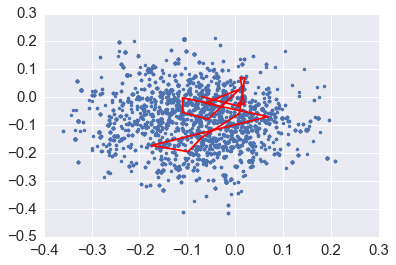

In [33]:
plt.plot(samples[1:M,0], samples[1:M,3], ".")
plt.plot(unique_samples[1:20,0], unique_samples[1:20,3],'r')
pass

In [24]:
import pymc3 as pm
import numpy.random as rng
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

clang: error: unknown argument: '-target-feature'
clang: error: unknown argument: '-sse4a'
clang: error: unknown argument: '-target-feature'
clang: error: unknown argument: '-target-feature'
clang: error: unknown argument: '-target-feature'
clang: error: unknown argument: '-tbm'
clang: error: unknown argument: '-target-feature'
clang: error: unknown argument: '-target-feature'
clang: error: unknown argument: '-fma4'
clang: error: unknown argument: '-target-feature'
clang: error: unknown argument: '-target-feature'
clang: error: unknown argument: '-prfchw'
clang: error: unknown argument: '-target-feature'
clang: error: unknown argument: '-target-feature'
clang: error: unknown argument: '-target-feature'
clang: error: unknown argument: '-target-feature'
clang: error: unknown argument: '-target-feature'
clang: error: unknown argument: '-target-feature'
clang: error: unknown argument: '-target-feature'
clang: error: unknown argument: '-target-feature'
clang: error: unknown argument: '-rtm'

00001	#include <Python.h>
00002	#include "theano_mod_helper.h"
00003	#include "structmember.h"
00004	#include <sys/time.h>
00005	
00006	#if PY_VERSION_HEX >= 0x03000000
00007	#include "numpy/npy_3kcompat.h"
00008	#define PyCObject_AsVoidPtr  NpyCapsule_AsVoidPtr
00009	#define PyCObject_GetDesc  NpyCapsule_GetDesc
00010	#define PyCObject_Check NpyCapsule_Check
00011	#endif
00012	
00013	#ifndef Py_TYPE
00014	#define Py_TYPE(obj) obj->ob_type
00015	#endif
00016	
00017	/**
00018	
00019	TODO: 
00020	- Check max supported depth of recursion
00021	- CLazyLinker should add context information to errors caught during evaluation. Say what node we were on, add the traceback attached to the node.
00022	- Clear containers of fully-useed intermediate results if allow_gc is 1
00023	- Add timers for profiling
00024	- Add support for profiling space used.
00025	
00026	
00027	  */
00028	static double pytime(const struct timeval * tv)
00029	{
00030	  struct timeval t;
00031	  if (!tv)
00032	    {
00033	 

Exception: Compilation failed (return status=1): clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-sse4a'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-tbm'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-fma4'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-prfchw'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-rtm'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-rdseed'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-hle'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-sha'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: unknown argument: '-target-feature'. clang: error: no such file or directory: '+cx16'. clang: error: no such file or directory: '+xsave'. clang: error: no such file or directory: '+bmi2'. clang: error: language not recognized: 'savec'. clang: error: no such file or directory: '+fsgsbase'. clang: error: no such file or directory: '+avx'. clang: error: no such file or directory: '+popcnt'. clang: error: no such file or directory: '+fma'. clang: error: no such file or directory: '+bmi'. clang: error: no such file or directory: '+aes'. clang: error: no such file or directory: '+rdrnd'. clang: error: language not recognized: 'saves'. clang: error: no such file or directory: '+sse4.1'. clang: error: no such file or directory: '+sse4.2'. clang: error: no such file or directory: '+avx2'. clang: error: no such file or directory: '+sse'. clang: error: no such file or directory: '+lzcnt'. clang: error: no such file or directory: '+pclmul'. clang: error: no such file or directory: '+f16c'. clang: error: no such file or directory: '+ssse3'. clang: error: no such file or directory: '+mmx'. clang: error: no such file or directory: '+cmov'. clang: error: language not recognized: 'op'. clang: error: no such file or directory: '+movbe'. clang: error: no such file or directory: '+xsaveopt'. clang: error: no such file or directory: '+sse2'. clang: error: no such file or directory: '+sse3'. 

In [25]:
niter = 7000
with pm.Model() as test_context:
    mu = pm.MvNormal('mu', 0, tau=cov, shape=5)
    y = pm.MvNormal('y', mu=mu, tau= cov, observed=X)
    step = pm.Metropolis()
    trace = pm.sample(niter,step=step)

NameError: name 'pm' is not defined

(7000, 5)

In [71]:
metropolis_samples = trace['mu']


In [140]:
unique_samples_met = np.array([metropolis_samples[0,:]])
# subset just accepted theta's
for i in range(1, niter):
    if all(metropolis_samples[i-1,:] != metropolis_samples[i,:]):
        unique_samples_met = np.vstack([unique_samples_met, metropolis_samples[i]])   

(2156, 5)

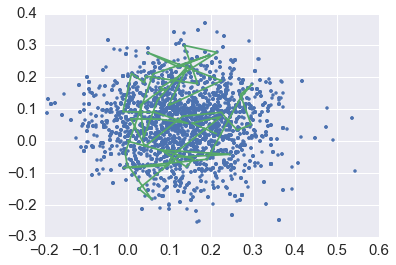

In [143]:
plt.plot(metropolis_samples[0:M,0], metropolis_samples[0:M,3], ".")
plt.plot(unique_samples_met[0:50,0], unique_samples_met[0:50,3])